# Division 1 or Division 3 Player?
This notebook is my first exposure to Machine Learning, namely PyTorch. Using a simple dataset on statistics for Ultimate Frisbee Players at the 2024 College Ultimate Championships. My model aims is trained based off the dataset, and uses the players statistics on the field in order to try and determine if they are a division 1 or a divsion 3 player.

Dataset Source: https://data.scorenetwork.org/disc_sports/ultimate_college_championship-2024.html
User: Maxwell
Original Source: Gavin Cassidy

In [305]:
import pandas as pd

In [306]:
# Get Dataset
source = "Dataset/ultimate_college_championship.csv"
df = pd.read_csv(source)
df.head()

,player,level,gender,division,team_name,Turns,Ds,Assists,Points,plus_minus,team_games,turns_per_game,ds_per_game,ast_per_game,pts_per_game,pls_mns_per_game
0,Jacques Nissen,Division 1,Men,Division 1 Men,Brown Brownian Motion,12,8,38,13,47,8,1.500000,1.000000,4.750000,1.625000,5.875
1,Cal Nightingale,Division 1,Men,Division 1 Men,Brown Brownian Motion,3,0,12,27,36,8,0.375000,0.000000,1.500000,3.375000,4.500
2,Faye Burdick,Division 1,Women,Division 1 Women,Colorado Quandary,6,12,16,13,35,7,0.857143,1.714286,2.285714,1.857143,5.000
3,Matthew Gregor,Division 3,Men,Division 3 Men,Franciscan Fatal,2,6,3,26,33,6,0.333333,1.000000,0.500000,4.333333,5.500
4,Frankie Saraniti,Division 3,Women,Division 3 Women,Carleton Eclipse,11,15,12,17,33,6,1.833333,2.500000,2.000000,2.833333,5.500


In [307]:
# Keep only Men and remove team name, player name, gender, and division
men_df = df.loc[df['gender'] == 'Men']
men_df = df.drop(columns=['team_name', 'player', 'gender', 'division'])
men_df.head()

,level,Turns,Ds,Assists,Points,plus_minus,team_games,turns_per_game,ds_per_game,ast_per_game,pts_per_game,pls_mns_per_game
0,Division 1,12,8,38,13,47,8,1.500000,1.000000,4.750000,1.625000,5.875
1,Division 1,3,0,12,27,36,8,0.375000,0.000000,1.500000,3.375000,4.500
2,Division 1,6,12,16,13,35,7,0.857143,1.714286,2.285714,1.857143,5.000
3,Division 3,2,6,3,26,33,6,0.333333,1.000000,0.500000,4.333333,5.500
4,Division 3,11,15,12,17,33,6,1.833333,2.500000,2.000000,2.833333,5.500


In [308]:
len(men_df)

1665

In [309]:
# Split dataset in three: training, valid, test
training_df = men_df.iloc[:555]
valid_df = men_df.iloc[555:1110]
test_df = men_df.iloc[1110:]

Since the labels are binary (Either Division 1 or Division 3), we convert the 'level' cell into a binary column, where 0 represents Div 1, and 1 represents Div 3.

In [310]:
# Converting y into binary where Division 1 is represented as 0, and Division 3 as 1
def convert(cell):
    if (cell == 'Division 1'):
        return 0
    return 1

In [311]:
# Separating the features with the labels
x_training = training_df.iloc[:, 7:].reset_index(drop=True)
y_training = training_df['level'].reset_index(drop=True).apply(convert)
x_valid = valid_df.iloc[:, 7:].reset_index(drop=True)
y_valid = valid_df['level'].reset_index(drop=True).apply(convert)

In [312]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [313]:
# Converting features and labels into tensors
train_x_tensor = torch.tensor(x_training.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_training.values, dtype=torch.float32).unsqueeze(1)
valid_x_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)

In [314]:
# Loading the training set and validator set
training_set = TensorDataset(train_x_tensor, train_y_tensor)
valid_set = TensorDataset(valid_x_tensor, valid_y_tensor)
batch = 16
train_loader = DataLoader(training_set, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch, shuffle=False)

# Classification 
My model is simple, since it only requires a binary output. This means for our function, we will use the BCELoss function and the Adam optimizer.

In [315]:
class DivisionClassifier(nn.Module):
    def __init__(self, input_size=5, hidden_size=32):
        super(DivisionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))


In [316]:
# Initializing criterion and optimizer
model=DivisionClassifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using 10 epochs to train the model

In [317]:
num_epochs = 25

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)

    training_loss = running_loss / len(train_loader.dataset)
    train_losses.append(training_loss)

    #validation
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_Y in valid_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            running_loss += loss.item() * batch_X.size(0)
    
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    #Epoch Stats
    print(f"Epoch {epoch + 1} / {num_epochs} - Train Loss: {training_loss}, Valid Loss: {val_loss}")

Epoch 1 / 25 - Train Loss: 0.6879079968005687, Valid Loss: 0.6809038011877386
Epoch 2 / 25 - Train Loss: 0.6714725700584618, Valid Loss: 0.6768355715382206
Epoch 3 / 25 - Train Loss: 0.6648538898777318, Valid Loss: 0.6740394055306375
Epoch 4 / 25 - Train Loss: 0.6591603454168853, Valid Loss: 0.6726369683806961
Epoch 5 / 25 - Train Loss: 0.6545423852430807, Valid Loss: 0.6710775461282816
Epoch 6 / 25 - Train Loss: 0.6511584063908001, Valid Loss: 0.6685284154909151
Epoch 7 / 25 - Train Loss: 0.648598896490561, Valid Loss: 0.6670592473433898
Epoch 8 / 25 - Train Loss: 0.645465900232126, Valid Loss: 0.6649625059720632
Epoch 9 / 25 - Train Loss: 0.6432553209700026, Valid Loss: 0.664320146607923
Epoch 10 / 25 - Train Loss: 0.6421621972376161, Valid Loss: 0.6630349798245473
Epoch 11 / 25 - Train Loss: 0.6403163549062368, Valid Loss: 0.6620048006375631
Epoch 12 / 25 - Train Loss: 0.6388893235911121, Valid Loss: 0.6616475839872618
Epoch 13 / 25 - Train Loss: 0.6381707067962166, Valid Loss: 0.66

In [318]:
import matplotlib.pyplot as plt

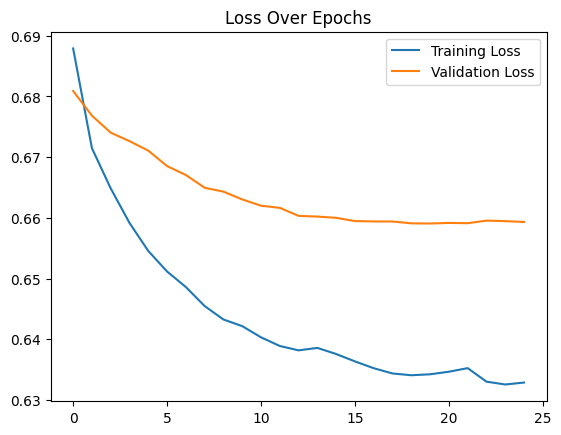

In [319]:
# Plotting the Loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

In [320]:
# Save model
torch.save(model.state_dict(), 'my_model.pth')

In [ ]:
# Loading Test data
x_test = test_df.iloc[:, 7:]
y_test = test_df['level'].apply(convert)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
test_set = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_set, batch_size = batch, shuffle=False)

In [322]:
# Writing out predictions with the model
model.eval()

with torch.no_grad():
    probs = model(x_test_tensor)

predictions = (probs > 0.5).int()

In [323]:
def first_elem(cell):
    return cell[0]
comparison = pd.DataFrame({'predictions': predictions.tolist(), 'actual': y_test})
comparison['predictions'] = comparison['predictions'].apply(first_elem)

In [324]:
# Compares the actual value with predictions and calculates the accuracy to 2 decimal places
accuracy = len(comparison.loc[comparison['predictions'] == comparison['actual']]) / len(comparison) * 100
print(f"Accuracy: {round(accuracy, 2)}%")

Accuracy: 56.4%
